#Построение более сложной модели с подбором гиперпараметров

В качестве более сложной модели был выбран градиентный бустинг. Данный метод успешно используется крупными компаниями (Google, IBM, Mirosoft) в задачах аналогичных моей.

In [ ]:
!pip install optuna
!pip install shap

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap

Произведём загрузку и стандартизацию данных

In [42]:
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, delimiter=';', skipinitialspace=True)

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop("HeartDiseaseorAttack", axis=1))

Выделим 20% на тестовую выборку и зафиксируем здесь и далее зерно ГПСЧ - 42

In [44]:
X = pd.DataFrame(X_scaled, columns=data.columns[1:])
y = data["HeartDiseaseorAttack"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Определение целевой функции для оптимизации (Optuna). Число еревьев, темп обучения и максимальную глубину здесь и далее беру, исходя из советов чата GPT о наиболее оптимальных и частоиспользуемых параметрах - это моя первая работа с подобной моделью, поэтому доверюсь всезнающему.

In [45]:
def objective(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 7)
    }

    model = XGBClassifier(**xgb_params, random_state=42)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

Запуск оптимизации с использованием Optuna

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

Получение лучших параметров (Optuna)

In [47]:
best_xgb_params_optuna = study.best_params
print("Лучшие параметры (Optuna):", best_xgb_params_optuna)

Лучшие параметры (Optuna): {'n_estimators': 76, 'learning_rate': 0.09541291997262301, 'max_depth': 3}


Обучение модели с лучшими параметрами (Optuna)

In [48]:
best_xgb_model_optuna = XGBClassifier(**best_xgb_params_optuna, random_state=42)
best_xgb_model_optuna.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09541291997262301,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=76, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Оценка качества на тестовой выборке (Optuna)

In [49]:
y_pred_proba_xgb_optuna = best_xgb_model_optuna.predict_proba(X_test)[:, 1]
roc_auc_xgb_optuna = roc_auc_score(y_test, y_pred_proba_xgb_optuna)
print(f"ROC-AUC для XGBoost (Optuna): {roc_auc_xgb_optuna}")

ROC-AUC для XGBoost (Optuna): 0.8006935368896281


Использование GridSearchCV для подбора гиперпараметров

In [50]:
params = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42),
                           param_grid=params,
                           scoring='roc_auc',
                           cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='roc_auc')

Получение лучших параметров от GridSearchCV

In [51]:
best_xgb_params_grid_search = grid_search.best_params_
print("Лучшие параметры (GridSearchCV):", best_xgb_params_grid_search)

Лучшие параметры (GridSearchCV): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


Обучение модели с лучшими параметрами от GridSearchCV

In [52]:
best_xgb_model_grid_search = XGBClassifier(**best_xgb_params_grid_search, random_state=42)
best_xgb_model_grid_search.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Оценка качества на тестовой выборке для модели от GridSearchCV

In [53]:
y_pred_proba_xgb_grid_search = best_xgb_model_grid_search.predict_proba(X_test)[:, 1]
roc_auc_xgb_grid_search = roc_auc_score(y_test, y_pred_proba_xgb_grid_search)
print(f"ROC-AUC для XGBoost (GridSearchCV): {roc_auc_xgb_grid_search}")

ROC-AUC для XGBoost (GridSearchCV): 0.799561155993822


Построим сравнительную визуализацию для обоих результатов

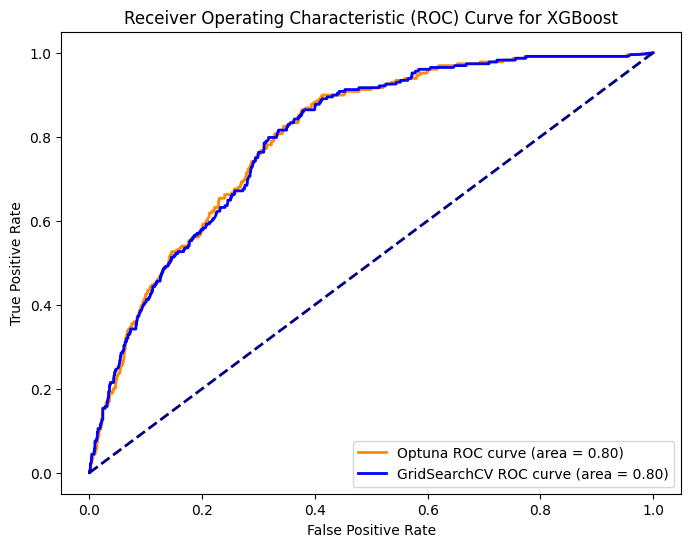

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_optuna, tpr_optuna, color='darkorange', lw=2, label=f'Optuna ROC curve (area = {roc_auc_optuna:.2f})')
plt.plot(fpr_grid_search, tpr_grid_search, color='blue', lw=2, label=f'GridSearchCV ROC curve (area = {roc_auc_grid_search:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

В целом - одно и тоже. Несколько странно, что у более простой модели, взятой мной в качестве бейзлайна результаты несколько лучше (~0.83). Это может говорить о том, что более простая модель работает лучше. Или, как ни странно, о том, что она переобучилась.

Инициализация explainer для SHAP (Optuna)

In [ ]:
explainer = shap.Explainer(best_xgb_model_optuna)
shap_values = explainer.shap_values(X_test)

Визуализация важности признаков с использованием SHAP для модели с лучшими параметрами (Optuna)

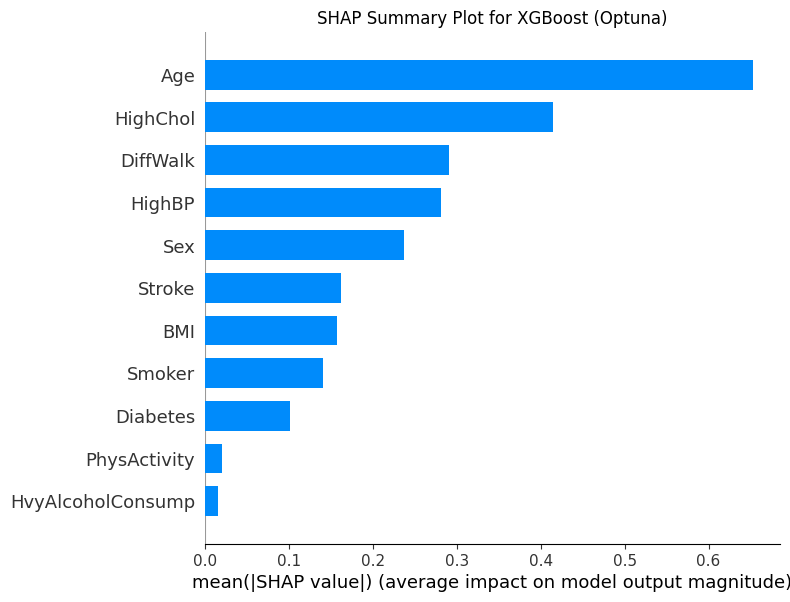

In [65]:
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.title('SHAP Summary Plot for XGBoost (Optuna)')
plt.show()Визуализация важности признаков с использованием SHAP для модели с лучшими параметрами (Optuna)

Инициализация explainer для SHAP для модели от GridSearchCV

In [ ]:
explainer_grid_search = shap.Explainer(best_xgb_model_grid_search)
shap_values_grid_search = explainer_grid_search.shap_values(X_test)

Визуализация важности признаков с использованием SHAP для модели от GridSearchCV

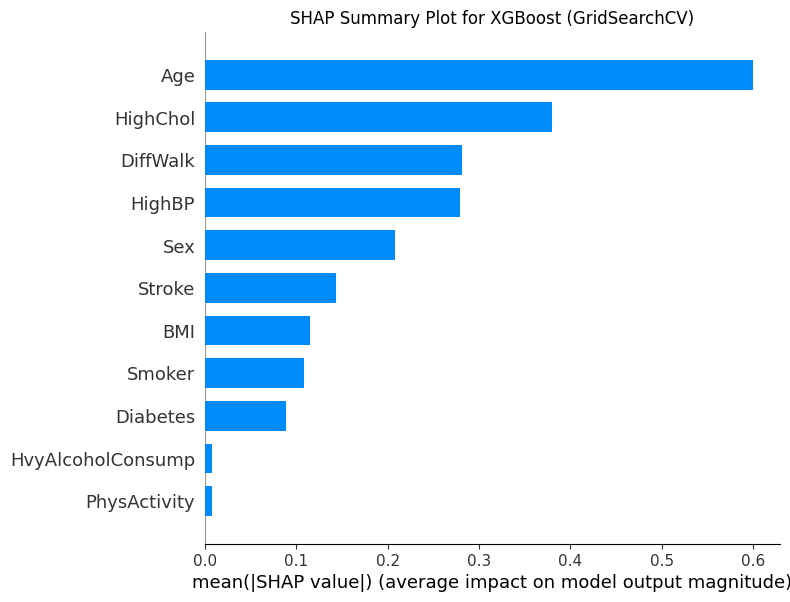

In [67]:
shap.summary_plot(shap_values_grid_search, X_test, plot_type='bar', show=False)
plt.title('SHAP Summary Plot for XGBoost (GridSearchCV)')
plt.show()

Полученные резлуьтаты практически одинаковы и показывают нам, что наибольшую роль в определении уровня риска инфаркта миокарда играет возраст. Меньшую, но весомую, роль играют высокий уровень холестерина, проблемы с ходьбой, высокое кровяное давление и пол. Средний урвоень влияния имеют пережитый инсульт, ИМТ, курение и диабет. В целом, это соответсвует действительности.

Наибольшее влияние на изнашивание сердца и сосудов оказывают возраст, холетсерин и высокое давление. Трудности с ходьбой могут быть признаком многих заболеваний, но зачастую они происходят именно из-за проблем с сердцем. Пережитый инсульт не является прямой причиной инфаркта миокарда, однако может указывать на проблемы с сердечно-сосудистой системой, которые позже могут стать причиной сердечного приступа. ИМТ, курение и диабет также вносят свою лепту, нанося вред сердцу. Роль пола человека в заболеваниях сердца была описана мной ранее.

Что интересно, согласно результатам, физическая активность и алкогольная зависимость играют мнимальную роль в развитии инфаркта миокарда. Выводы делайте сами...

Возможно, есть ошибки и недочёты в моей работе, возможно выборка не совсем релевантна. Но я имею право предположить, что алкоголь, хоть и наносит вред всем системам организма, однако может иметь и положительное (прямое и косвенное) влияние на сердечно-сосудистую систему (но я вам этого не говорил). Основное положительное влияние - повышение настроения и снятие стресса - эти факторы играют высокую роль в развитии инсульта и инфаркта миокарда, однако измерить и оценить их сложно, поэтому в мою выборку они не вошли. Также не стоит забывать, что алкоголь - это не всегда чистый спирт. Зачастую это различные напитки, которые содержат в себе биологически активные вещества, способные, согласно некоторым исследованиям, снижать риски проблем с сердцем. Помимо этого, стоит учитывать, что наш организм - система, способная адаптироваться к вредоносным воздействиям, если те имеют регулярный характер. Пьющие люди не получают такого выского вреда от высоких доз алкоголя, какой получают непьющие. Суммарно, положителньные стороны снижают влияние отрицательных. Возможно, поэтому получен такой резлуьтат.

Что касется уровня физической активности, далеко не каждая физическая активность полезна. Нередко высокая физическая активность наносит больше вреда, нежели пользы. Да и в целом, согласно недавним исследованиям, польза физической активности для сердца сильно преувеличена. На самом деле изначально не было особо веских доказательств для подобных предположений. Доказательная медицина с сомнением смотрит даже на лечебную физкультуру (в плане лечения последствий и профилактики появления инфаркта и инсульта), не говоря уже о классических видах физнагрузок. Ситуация, в итоге, похожа на ситуацию с алкоголем, но наоборот - воздействие переоценено, а отрицательные стороны невелируют стороны положительные.